# **Step2_AI 강사 Agent v2.0**

## **0. 미션**

### **미션③ : 모듈 고도화1**
다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.

* 입력 프롬프트 추가 : 강의 목소리, 톤 조절, 강의 스타일 지침
* 정보 분해 : 여러 슬라이드를 저장하고 관리하기 위한 폴더 준비, 불필요한 정보 제거, 제목 추출
* 페이지별 내용 생성 : 슬라이드 내 정보 뿐만 아니라 부연 설명을 위한 검색 기능 추가
* 강의 스크립트 생성 : 전체 강의 내용을 참조하여 강의 흐름을 구상하고,
                                   현재 페이지 강의 스크립트 작성
* 내용 검토 : 페이지 내용과 강의 스크립트 비교, 강의 스크립트 흐름 적절한지 검토




### **미션④ : AI 강사 Agent 완성**
* 모듈 고도화2(다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.)
    * 음성 변환 : 강의 목소리, 톤 조절 음성 변환
    * 영상 제작 :
        * 각 페이지 : 음성과 슬라이드 스냅샷 이미지 합성하여 영상 제작하기
        * 전체 강의 영상 : 각 슬라이드 강의를 전체 슬라이드 강의 영상으로 합치기
* 웹 화면 연결(gradio)
    * 음성 변환 : 강의 목소리, 톤 조절 프롬프트 기반 음성 변환
* 전체 Agent 그래프 구축
    * 전체를 Agent 그래프로 엮기


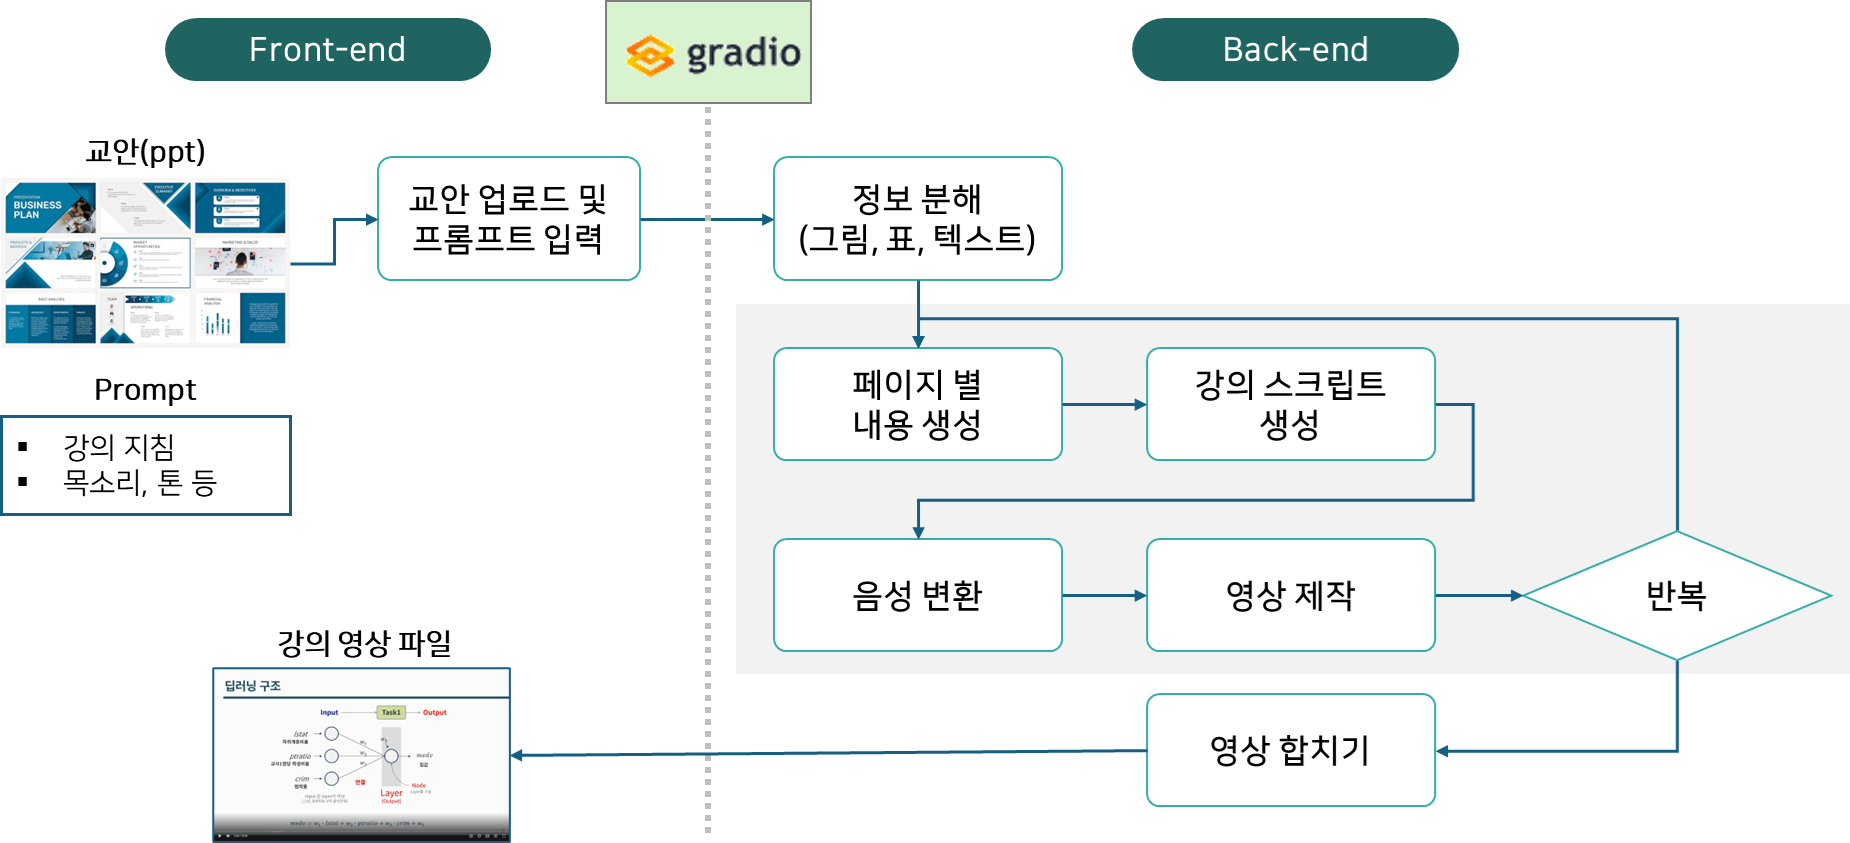

## **1. 환경준비**

### (1) 구글 드라이브

* 구글 드라이브 폴더 생성
    * 새 폴더(project_multi_modal)를 생성하고
    * 제공 받은 파일을 업로드

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 한글 폰트 준비
* 한글 폰트 설치 및 설정 코드
* 영상 제작 등 한글 사용시 필요

In [2]:
!apt-get -y install ffmpeg libreoffice poppler-utils poppler-data locales \
                   fonts-noto-cjk fonts-noto-cjk-extra fonts-nanum fonts-unfonts-core
!sed -i 's/^# *ko_KR.UTF-8 UTF-8/ko_KR.UTF-8 UTF-8/' /etc/locale.gen
!locale-gen ko_KR.UTF-8
!update-locale LANG=ko_KR.UTF-8
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.11).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  apparmor at-spi2-core ca-certificates-java default-jre default-jre-headless
  dictionaries-common firebird3.0-common firebird3.0-common-doc
  firebird3.0-server-core firebird3.0-utils fonts-crosextra-caladea
  fonts-crosextra-carlito fonts-dejavu fonts-dejavu-core fonts-dejavu-extra
  fonts-liberation2 fonts-linuxlibertine fonts-noto-core fonts-noto-extra
  fonts-noto-mono fonts-noto-ui-core fonts-opensymbol fonts-sil-gentium
  fonts-sil-gentium-basic gsettings-desktop-schemas gstreamer1.0-gl
  gstreamer1.0-gtk3 gstreamer1.0-plugins-base hunspell-en-us java-common
  libabsl20210324 libabw-0.1-1 libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libboost-filesy

In [3]:
%%bash
mkdir -p ~/.config/fontconfig
cat > ~/.config/fontconfig/fonts.conf <<'EOF'
<?xml version="1.0"?>
<!DOCTYPE fontconfig SYSTEM "fonts.dtd">
<fontconfig>

  <!-- ▷ 한국어 텍스트엔 Noto Sans CJK KR을 우선 사용 -->
  <match target="pattern">
    <test name="lang" compare="eq"><string>ko</string></test>
    <edit name="family" mode="prepend" binding="strong">
      <string>Noto Sans CJK KR</string>
    </edit>
  </match>

  <!-- ▷ 일반 가족명에도 기본 대체 추가 -->
  <alias><family>sans-serif</family><prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>serif</family><prefer><family>Noto Serif CJK KR</family></prefer></alias>
  <alias><family>monospace</family><prefer><family>Noto Sans Mono CJK KR</family></prefer></alias>

  <!-- ▷ Windows/macOS/웹에서 흔한 한글 폰트들을 Noto로 매핑 -->
  <alias><family>Malgun Gothic</family>        <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>맑은 고딕</family>             <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Apple SD Gothic Neo</family>  <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>AppleGothic</family>          <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Pretendard</family>           <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Pretendard Variable</family>  <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>NanumSquare</family>          <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Spoqa Han Sans</family>       <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>KoPub</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Gulim</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Dotum</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Batang</family>               <prefer><family>Noto Serif CJK KR</family></prefer></alias>
</fontconfig>
EOF
fc-cache -fv


/usr/share/fonts: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype/linux-libertine: caching, new cache contents: 13 fonts, 0 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 80 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 11 dirs
/usr/share/fonts/truetype/crosextra: caching, new cache contents: 8 fonts, 0 dirs
/usr/sh

### (3) 라이브러리

* 필요한 라이브러리 설치

In [4]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=7b42d0dbc111a2d2e9afcdd41b0911e681b30fd046b9acd9ae978af364e242d0
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [5]:
!apt-get -y install ffmpeg libreoffice poppler-utils
!pip install python-pptx pillow langgraph google-search-results gradio -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libreoffice is already the newest version (1:7.3.7-0ubuntu0.22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 20.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver d

* 라이브러리 로딩

In [6]:
import os, re, textwrap, subprocess, json, base64, mimetypes, shlex
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Optional, TypedDict, Any
from PIL import Image, ImageDraw
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE
from openai import OpenAI
from google.colab import files
from IPython.display import Audio, display, Video

from serpapi import GoogleSearch

### (4) OpenAI API Key 확인
* 구글드라이브에 생성한 폴더 'project_multi_modal'에서
* api_key.txt 파일 안에 각자 발급 받은 키를 저장합니다.
    * **openai api key**
    * **SERPAPI_API_KEY**

In [8]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/langchain/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

In [ ]:
# def load_api_keys(filepath="api_key.txt"):
#     with open(filepath, "r") as f:
#         for line in f:
#             line = line.strip()
#             if line and "=" in line:
#                 key, value = line.split("=", 1)
#                 os.environ[key.strip()] = value.strip()

# # path = '/content/drive/MyDrive/project_multi_modal/'
# path = '/content/drive/MyDrive/langchain/'
# # API 키 로드 및 환경변수 설정
# load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [9]:
print(os.environ['OPENAI_API_KEY'][:30])
print(os.environ['SERPAPI_API_KEY'][:30])

sk-proj-8H-O_y4-37YTYFAWHonNr-
f1751f4795af0ee6f1e85a58da2ef2


### (5) 유용한 함수들 제공
* 다음은 프로젝트를 수행하는데 유용한 함수들입니다.
* 이 함수들의 내용을 확인하고 필요시 활용하여 개인 과제를 수행합니다.(꼭 활용해야 하는 것은 아닙니다.)

* 공백 제거 함수

In [10]:
def clean_text(s):
    return re.sub(r"\s+", " ", s).strip()

* 긴 문자열을 문장 단위로 나누는 문장 분리기

In [11]:
def split_sents(t: str) -> List[str]:
    parts = re.split(r'([\.?!])', t)
    merged = []
    for i in range(0, len(parts)-1, 2):
        sent = (parts[i] + parts[i+1]).strip()
        if sent: merged.append(sent)
    if len(parts) % 2 == 1 and parts[-1].strip():
        merged.append(parts[-1].strip())
    return [s for s in merged if s]

* 오디오 길이 계산

In [12]:
def ffprobe_duration(path: str) -> float:
    out = subprocess.check_output([
        "ffprobe","-v","error","-show_entries","format=duration",
        "-of","default=noprint_wrappers=1:nokey=1", path]).decode().strip()
    return float(out)

* 이미지를 base64로 변환

In [13]:
def img_to_data_url(path: str) -> str:
    mime = mimetypes.guess_type(path)[0] or "image/png"
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime};base64,{b64}"

* 배경 이미지와 오디오 합쳐서 MP4 영상 만들기

In [14]:
def render_mp4(image_path: str, audio_path: str, out_mp4: str,
               width=1920, height=1080, ):

    dur = ffprobe_duration(audio_path)

    vf = (f"scale={width}:{height}:force_original_aspect_ratio=decrease,"
          f"pad={width}:{height}:(ow-iw)/2:(oh-ih)/2:color=black"  )

    # FFmpeg 명령
    cmd = ["ffmpeg", "-y",
            "-loop", "1", "-i", image_path,   # 정지 이미지 입력
            "-i", audio_path,                 # 오디오 입력
            "-t", str(dur),                   # 길이 = 오디오 길이
            "-vf", vf,                        # 비디오 필터
            "-c:v", "libx264", "-preset", "veryfast", "-crf", "20",
            "-c:a", "aac", "-b:a", "192k",
            "-pix_fmt", "yuv420p",
            "-movflags", "+faststart",        # 웹/브라우저 재생 친화
            out_mp4]
    subprocess.check_call(cmd)  # 외부 프로그램(FFmpeg)을 파이썬 프로세스에서 실행하고, 성공했는지 확인

* ppt 슬라이드를 배경 이미지로 저장
    * 강의 영상에서 사용할 배경 이미지 생성하기
    * ppt를 pdf로 변환한 뒤 다시 이미지로 변환

In [15]:
# 슬라이드를 이미지로 저장
def export_slide_as_png(state: dict, dpi: int = 220) -> dict:
    work_dir = Path(state["work_dir"]).expanduser().resolve()
    work_dir.mkdir(parents=True, exist_ok=True)

    pptx = Path(state["pptx_path"]).expanduser().resolve()
    if not pptx.exists():
        raise FileNotFoundError(f"PPTX 없음: {pptx}")

    idx = int(state.get("slide_index", 0))  # 0-based
    page_no = idx + 1
    out_prefix = work_dir / "slide_img"

    # ▶ 폰트/로케일이 하위 프로세스에 확실히 전달되도록
    env = os.environ.copy()
    env.update({
        "LANG": "ko_KR.UTF-8",
        "LC_ALL": "ko_KR.UTF-8",
    })

    # --- A) 직접 PNG 변환 시도 (Impress filter) ---
    before_png = set(work_dir.glob("*.png"))
    png_cmd = [
        "soffice","--headless",
        "-env:UserInstallation=file:///tmp/lo_profile",
        "--convert-to", "png:impress_png_Export",
        "--outdir", str(work_dir),
        str(pptx),
    ]
    res_png = subprocess.run(png_cmd, capture_output=True, text=True, env=env)

    created_png = [p for p in work_dir.glob("*.png") if p not in before_png]
    # 페이지 번호가 붙는 경우가 있고, 아닌 경우도 있어 최신 파일 선택
    candidate = None
    exact = [p for p in created_png if p.stem.endswith(f"-{page_no}")]
    if exact:
        candidate = max(exact, key=lambda p: p.stat().st_mtime)
    elif created_png:
        candidate = max(created_png, key=lambda p: p.stat().st_mtime)

    if candidate and candidate.exists():
        state["slide_image"] = str(candidate)
        return state

    # --- B) 폴백: PDF → PNG  ---
    target_pdf = work_dir / f"{pptx.stem}.pdf"
    before_pdf = {p.name for p in work_dir.glob("*.pdf")}
    lo_cmd = [
        "soffice","--headless",
        "-env:UserInstallation=file:///tmp/lo_profile",
        "--convert-to","pdf:impress_pdf_Export",
        "--outdir", str(work_dir),
        str(pptx),
    ]
    res_pdf = subprocess.run(lo_cmd, capture_output=True, text=True, env=env)

    if target_pdf.exists():
        pdf_path = target_pdf
    else:
        created = [p for p in work_dir.glob("*.pdf") if p.name not in before_pdf]
        if created:
            pdf_path = max(created, key=lambda p: p.stat().st_mtime)
        else:
            print("LibreOffice 변환 실패")
            print("stdout:", res_pdf.stdout)
            print("stderr:", res_pdf.stderr)
            raise RuntimeError("PPTX → PDF 변환 실패")

    ppm_cmd = [
        "pdftoppm",
        "-f", str(page_no), "-l", str(page_no),
        "-png", "-r", str(dpi),
        str(pdf_path),
        str(out_prefix)
    ]
    res2 = subprocess.run(ppm_cmd, capture_output=True, text=True, env=env)
    png_path = Path(f"{out_prefix}-{page_no}.png")
    state["slide_image"] = str(png_path)
    return state


* 영상 합치기 : 여러 영상 경로를 리스트로 입력 받아 합치기

In [16]:
def concat_videos_ffmpeg(video_paths: List[str], out_path: str, reencode: bool=False):
    list_path = out_path + ".txt"
    with open(list_path, "w", encoding="utf-8") as f:
        for v in video_paths:
            f.write(f"file '{os.path.abspath(v)}'\n")
    if reencode:
        cmd = [
            "ffmpeg","-y","-safe","0","-f","concat","-i",list_path,
            "-vf","format=yuv420p",
            "-c:v","libx264","-preset","veryfast",
            "-c:a","aac","-b:a","192k",
            out_path
        ]
    else:
        cmd = ["ffmpeg","-y","-safe","0","-f","concat","-i",list_path,"-c","copy",out_path]
    subprocess.check_call(cmd)

## **2. 미션③ : 모듈 고도화1**
(다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.)
* 입력 프롬프트 추가 : 강의 목소리, 톤 조절, 강의 스타일 지침
* 정보 분해 : 여러 슬라이드를 저장하고 관리하기 위한 폴더 준비, 불필요한 정보 제거, 제목 추출
* 페이지별 내용 생성 : 슬라이드 내 정보 뿐만 아니라 부연 설명을 위한 검색 기능 추가
* 강의 스크립트 생성 : 전체 강의 내용을 참조하여 강의 흐름을 구상하고,
                                   현재 페이지 강의 스크립트 작성
* 내용 검토 : 페이지 내용과 강의 스크립트 비교, 강의 스크립트 흐름 적절한지 검토

### (1) 파일 입력
* ppt 파일은 각 조에서 자체 준비
* 테스트용 샘플 ppt 제공 : sample2_test.pptx



In [17]:
# 파일 업로드
uploaded = files.upload()
pptx_path = list(uploaded.keys())[0]

Saving sample2_test.pptx to sample2_test.pptx


In [18]:
# 사용자 프롬프트
USER_PROMPT = {
    "voice": "alloy",
    "tone": "친절하고 명료한 강의 톤",
    "style": "예시와 핵심 요점 중심"
}

# 출력 dir 만들기
WORK_DIR = "./step2_output"
MEDIA_DIR = "./step2_output/media"
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MEDIA_DIR, exist_ok=True)

### (2) State 선언

* 각 노드의 입출력 관리를 위한 State 구성
    * 각 함수(노드)에서 채워가며 관리해야 할 정보를 도출
    * 이를 하나의 State로 정의


In [19]:
VOICE_MAP = {
    "ko": "alloy",
    "en": "verse",
    "ja": "shimmer",
    "zh-cn": "coral",
    "fr": "sage",
}

LANG_MAP = {
    "ko": "한국어",
    "en": "English",
    "ja": "日本語",
    "zh-cn": "中文",
    "fr": "Français",
}

In [20]:
class SlideData(TypedDict, total=False):
    # 추출 산출물
    title: str
    texts: List[str]
    tables: List[List[List[str]]]
    images: List[str]
    slide_image: Optional[str]

    # SerpAPI 검색 결과
    search_summary : str

    # 생성 산출물
    page_content: str
    script: str

    # 미디어 산출물
    audio: str
    video_path: str


class State(TypedDict, total=False):
    # 입력/기본
    pptx_path: str
    work_dir: str
    prompt: Dict
    slide_index: int

    # 전체 슬라이드 데이터
    slides: List[SlideData]

    # 마지막단계 요약 산출물
    summary_script: str
    summary_audio: str
    summary_video: str

    # 최종 미디어 산출물
    merged_video: str


### (3) 정보 분해
* 목적: 전체 슬라이드의 텍스트/표/이미지/스냅샷 수집 → state["slides"] 적재
* 입력: pptx_path, work_dir
* 출력: 슬라이드마다, text, image, text, 스냅(스크린샷) 등 저장
* 처리:
    * python-pptx로 텍스트/표/이미지 추출
    * 제목 추출
    * export_slide_as_png로 snap 생성

* 노드 함수 생성

In [21]:
def node_parse_all(state: State) -> State:
    pptx_path = state['pptx_path']
    work_dir = state['work_dir']

    slides = state.get("slides", [])

    ppt = Presentation(pptx_path)
    global total_slides
    total_slides = len(ppt.slides)
    print(f"[Debug] 📝  정보 분해 시작...")

    for slide_idx, slide in enumerate(ppt.slides):
        texts: List[str] = []
        tables: List[List[List[str]]] = []
        images: List[str] = []
        # 텍스트 추출
        for idx, shape in enumerate(slide.shapes) :
            if shape.has_text_frame:
                text = '\n'.join(p.text for p in shape.text_frame.paragraphs)
                text = clean_text(text)
            if text.strip():
                texts.append(text)
            # 테이블 추출
            if shape.shape_type == MSO_SHAPE_TYPE.TABLE :
                tbl = [[clean_text(cell.text) for cell in row.cells] for row in shape.table.rows]
                tables.append(tbl)
            # 이미지 추출
            if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
                ext = shape.image.ext #이미지 원본 확장자
                img_path = os.path.join(MEDIA_DIR, f"slide{slide_idx}_img_{len(images)}.{ext}") #저장경로
                with open(img_path, "wb") as f :
                    f.write(shape.image.blob)
                images.append(img_path)

        title = ""
        from pptx.enum.shapes import PP_PLACEHOLDER
        for shape in slide.shapes:
            if shape.is_placeholder and shape.placeholder_format.type == PP_PLACEHOLDER.TITLE :
                title = shape.text.strip()
                break
        if not title and texts: # 따로 제목 요소가 없으면, 텍스트의 첫번째 부분을 제목으로 설정
            title = texts[-1].split('\n')[0]


        snap_state = {
            "pptx_path": pptx_path,
            "work_dir": work_dir,
            "slide_index": slide_idx,
            "slide_image": ""
        }
        try:
            snap = export_slide_as_png(snap_state)
            slide_image = snap_state.get("slide_image")
            print(f"[Debug] 슬라이드 이미지 생성 {slide_image}")
        except Exception as e:
            print(f"[Error] 슬라이드{slide_idx} 이미지 생성 실패: {e}")
            slide_image = ""


        slides.append({
            "title": title,
            "texts": texts,
            "tables": tables,
            "images" : images,
            "slide_image": slide_image,
        })

        print(f"[Debug] Slide{slide_idx} : {len(texts)} texts, {len(tables)} tables, {len(images)} images")

    state.update({
        "slides": slides
    })

    print(f"[Debug] ✅ {slide_idx+1}개 슬라이드 파싱 완료")
    return state

* 노드 테스트

In [22]:
state: State = {
    "pptx_path": pptx_path,
    "work_dir": WORK_DIR,
    "prompt": USER_PROMPT,
    "slide_index": 0
}
prev_context = ""
total_slides = 0
state = node_parse_all(state)

[Debug] 📝  정보 분해 시작...
[Debug] 슬라이드 이미지 생성 /content/step2_output/sample2_test.png
[Debug] Slide0 : 4 texts, 0 tables, 1 images
[Debug] 슬라이드 이미지 생성 /content/step2_output/slide_img-2.png
[Debug] Slide1 : 4 texts, 0 tables, 1 images
[Debug] 슬라이드 이미지 생성 /content/step2_output/slide_img-3.png
[Debug] Slide2 : 4 texts, 1 tables, 0 images
[Debug] ✅ 3개 슬라이드 파싱 완료


In [23]:
state

{'pptx_path': 'sample2_test.pptx',
 'work_dir': './step2_output',
 'prompt': {'voice': 'alloy',
  'tone': '친절하고 명료한 강의 톤',
  'style': '예시와 핵심 요점 중심'},
 'slide_index': 0,
 'slides': [{'title': '모델 성능 모니터링',
   'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화',
    '모델 성능 모니터링',
    '모델 성능 모니터링',
    '1'],
   'tables': [],
   'images': ['./step2_output/media/slide0_img_0.png'],
   'slide_image': '/content/step2_output/sample2_test.png'},
  {'title': 'ML 모델에 영향을 줄 수 있는 요인',
   'texts': ['최초 정의한 문제의 컨셉 변화(Concept Drift) 시간 경과에 따라 데이터 변수 또는 패턴 간의 관계가 지속적으로 변할 수 있음. 모델 환경에 갑작스럽고 예상치 못한 변화가 발생하여 성능에 상당한 영향을 미칠 수 있는 상황 (예 : COVID-19)',
    'ML 모델에 영향을 줄 수 있는 요인',
    'ML 모델에 영향을 줄 수 있는 요인',
    '2'],
   'tables': [],
   'images': ['./step2_output/media/slide1_img_0.png'],
   'slide_image': '/content/step

In [24]:
total_slides

3

### (4) 페이지별 내용 생성

* 목적: 슬라이드 내용을 text로 정리
* 입력 : text, image, 표, 슬라이드 제목
* 출력 : 슬라이드 설명문
* 처리
    * 슬라이드 제목으로 SerpAPI 검색 및 요약
    * text, image, 표에 대한 설명문 생성
    * 전체 설명문 작성

#### **1) 외부 검색 노드**


In [25]:
!pip install google-search-results

In [27]:
def serpapi_search_by_title(title: str, num: int = 4) -> str:
    try:
        api_key = os.environ.get("SERPAPI_API_KEY")
        if not api_key:
            return "SerpAPI 키가 설정되지 않았습니다."

        params = {
            "engine": "google",
            "q": title,
            "hl": "ko",
            "num": num,
            "api_key": api_key
        }

        search = GoogleSearch(params)
        results = search.get_dict()

        snippets = []

        # (1) knowledge_graph 설명
        kg = results.get("knowledge_graph", {})
        if "description" in kg:
            src = kg.get("source", {}).get("name", "").strip()
            snippets.append(f"{kg['description']} (출처: {src})")

        # (2) organic_results의 snippet 수집
        for res in results.get("organic_results", []):
            s = res.get("snippet")
            if s:
                snippets.append(s)

        if not snippets:
            return "검색 결과가 충분하지 않습니다."

        return "\n".join(snippets[:num])

    except Exception as e:
        print(f"[exception] SerpAPI 검색 실패: {e}")
        return "검색 중 오류가 발생했습니다."




def node_tool_search(state: State) -> State:
    slides = state.get("slides", [])
    current_idx = state.get("slide_index", 0)

    slide = slides[current_idx]
    title = slide.get("title", "")
    if not title:
        slide["search_summary"] = "제목이 없어 검색을 수행하지 못했습니다."

    summary = serpapi_search_by_title(title, 4)
    slide["search_summary"] = summary

    slides[current_idx] = slide
    state.update({
        "slides": slides
    })

    return state

#### **2) 내용 생성 함수**

In [28]:
LLM_MODEL = "gpt-4o-mini"
TTS_MODEL = "gpt-4o-mini-tts"

In [29]:
def table_to_text(table: List[List[str]], max_rows: int = 6) -> str:
  if not table: return ""
  prev = table[:max_rows]
  lines = ["|".join(row) for row in prev]
  return '\n'.join(lines)

In [30]:
def node_generate_page_content(state: State) -> State:
    client = OpenAI()

    slides = state.get("slides", [])
    current_idx = state.get("slide_index", 0)

    slide = slides[current_idx]

    title = slide.get("title", "제목 없음")
    texts = slide.get("texts", [])
    tables = slide.get("tables", [])
    images = slide.get("images", [])
    search_summary = slide.get("search_summary", "")

    text_content = "\n".join(texts) if texts else "텍스트 없음"
    table_text = table_to_text(tables[0], 6) if tables else "표 없음"

    image_urls = []
    for image_path in images[:3]:
        try:
            data_url = img_to_data_url(image_path)
            image_urls.append({"type": "image_url", "image_url": {"url": data_url}})
        except Exception as e:
            print(f"[Exception] 이미지 변환 실패: {image_path} ({e})")


    # ---------- 프롬프트 ----------
    content_txt = textwrap.dedent(f"""
    슬라이드 제목: {title} \n
    🔍 [검색 요약 결과]
    {search_summary} \n
    🔹 텍스트 내용:
    {text_content} \n
    🔹 표 내용 (일부 행):
    {table_text} \n
    위 정보를 바탕으로 다음 형식으로 작성하세요: \n
    [텍스트 설명문]
    - 텍스트의 핵심 개념과 주요 요점을 명료하게 설명 \n
    [이미지 설명문]
    - 슬라이드의 이미지가 전달하는 시각적 정보나 의미를 요약 \n
    [표 설명문]
    - 표가 비교하거나 보여주는 핵심 정보를 서술형으로 요약 \n
    📝 [전체 슬라이드 설명문]
    - 위의 모든 내용을 종합하여 5~7문장으로 자연스럽게 연결된 설명문 작성
    - 불릿 금지, 과장 금지, 자연스럽고 친절한 강의 톤
    """)

    sys_prompt = "당신은 교육용 슬라이드를 분석해 각 요소를 명료하게 설명하는 전문 강의 요약 작성자입니다."

    resp = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": [{"type": "text", "text": content_txt}, *image_urls]}
        ],
        temperature=0.5,
        max_tokens=900
    )

    result = resp.choices[0].message.content.strip()
    # ---------- 결과 저장 ----------
    slide["page_content"] = result

    slides[current_idx] = slide
    state.update({
        "slides": slides
    })

    return state

* 노드 테스트

In [31]:
state = node_generate_page_content(state)

In [32]:
state

{'pptx_path': 'sample2_test.pptx',
 'work_dir': './step2_output',
 'prompt': {'voice': 'alloy',
  'tone': '친절하고 명료한 강의 톤',
  'style': '예시와 핵심 요점 중심'},
 'slide_index': 0,
 'slides': [{'title': '모델 성능 모니터링',
   'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화',
    '모델 성능 모니터링',
    '모델 성능 모니터링',
    '1'],
   'tables': [],
   'images': ['./step2_output/media/slide0_img_0.png'],
   'slide_image': '/content/step2_output/sample2_test.png',
   'page_content': "### [텍스트 설명문]\n모델 성능 모니터링은 머신러닝 모델이 프로덕션 환경에서 지속적으로 성능과 동작을 추적하고 분석하는 과정입니다. 모델은 배포 이후에도 품질 저하, 데이터 문제, 사용 환경의 변화 등 여러 위험에 직면할 수 있습니다. 주요 리스크로는 데이터 및 개념 드리프트, 데이터 품질 문제, 적대적 공격, 모델 오류의 전파 등이 있으며, 이러한 문제를 조기에 탐지하고 근본 원인을 분석하는 것이 중요합니다. 이를 통해 모델의 동작을 이해하고 투명하게 문서화할 수 있습니다.\n\n### [이미지 설명문]\n슬라이드에는 '예측 대 실제'를 나타내는 그래프가 포함되어 있으며, 빨간색 선은 예측 값을, 녹색 선은 

### (5) 강의 스크립트 생성

* 목적 : 슬라이드 요약(page_content)을 기반으로 60~90초 분량의 발표 대본(스크립트)을 작성하고 저장
* 입력:
    * 슬라이드 설명문
    * tone, 말투 지시 프롬프트
    * 스크립트 저장 디렉토리
    * 이전 페이지의 강의 스크립트(맥락/흐름 파악용)
* 출력: 생성된 발표 스크립트

* 노드 함수 생성

In [33]:
def node_generate_script_with_context(state: State) -> State:

    client = OpenAI()
    slides = state.get("slides", [])  # 여러 개의 슬라이드 처리를 위해 변경
    current_idx = state.get("slide_index", 0)

    prompt_config = state.get("prompt", {}) # 동일
    work_dir = state.get("work_dir", "./") # 동일

    tone = prompt_config.get("tone", "친절하고 명료한 강의 톤") # 동일
    style = prompt_config.get("style", "예시와 핵심 요점 중심")

    os.makedirs(work_dir, exist_ok=True)

    print(f"[Debug] 🎤 [{tone} / {style}] 스타일로 발표 스크립트 생성 시작...")

    global prev_context

    slide = slides[current_idx]
    title = slide.get("title", f"슬라이드{current_idx}")
    page_content = slide.get("page_content", "")

    if current_idx == 0:
        sys_prompt = f"""
        당신은 전문 강의 스크립트 작성자입니다.
        아래 슬라이드 내용을 바탕으로 첫 슬라이드의 도입 스크립트를 작성하세요.
        - '안녕하세요. 오늘은 {title}에 대해 살펴보겠습니다.'로 시작
        - {tone}, {style} 말투로 작성
        - 완결된 문장으로 마무리
        - 분량: 60~90초 (약 500~700자)
        - 슬라이드 내 시각적 요소(그래프, 표, 이미지) 설명을 자연스럽게 언급
        """
    # elif current_idx == total_slides - 1:
    #     #  [2] 마지막 슬라이드 프롬프트 (마무리 멘트 추가)
    #     sys_prompt = f"""
    #     당신은 전문 강의 스크립트 작성자입니다.
    #     마지막 슬라이드({title})의 강의 스크립트를 작성하세요.
    #     - 앞 슬라이드의 흐름을 자연스럽게 이어갈 것
    #     - {tone}, {style} 말투로 설명
    #     - 강의 전체를 요약하며 자연스럽게 마무리

    #     * 가장 중요
    #     - 절대로 '...' 또는 '…'으로 끝내지 말고, 완전한 문장으로 끝낼 것
    #     - 마지막 문장은 항상 완결된 형태여야 하며, 문장이 중간에서 끊기지 않도록 하세요

    #     - 끝에는 “이상으로 강의를 마치겠습니다. 감사합니다.” 등의 마무리 멘트를 포함
    #     - 분량: 60~90초 (약 500~700자)
    #     """
    else:
        sys_prompt = f"""
        당신은 전문 강의 스크립트 작성자입니다.
        이전 슬라이드의 내용을 참고하여 다음 슬라이드({title})로 자연스럽게 이어지는 발표 스크립트를 작성하세요.
        - "안녕하세요"로 시작하지 말 것
        - "이제 다음"처럼 말흐림 표현 금지
        - 앞 슬라이드의 맥락을 1~2문장으로 요약하며 연결
        - {tone}, {style} 말투로 자연스럽게 설명
        - 완결된 문장으로 끝낼 것
        - 분량: 60~90초 (약 500~700자)
        """

    prompt_txt = f"""
    당신은 발표 대본을 작성하는 전문가입니다. \n
    아래 내용을 참고하여 발표 스크립트를 작성하세요. \n
    [이전 슬라이드 요약]
    {prev_context if prev_context else '(없음)'} \n
    [현재 슬라이드 제목]
    {title} \n
    [현재 슬라이드 내용]
    {page_content} \n
    위 정보를 종합해 강의 발표용 스크립트를 작성하세요.
    오직 스크립트 본문만 작성하세요.
    """

    resp = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[
              {'role': "system", 'content': sys_prompt},
              {'role': "user", 'content': prompt_txt}
        ],
        temperature=0.7,
        max_tokens=1200
        )

    # script = resp.choices[0].message.content.strip()
    # (추가) GPT 응답이 없을 때 대비
    script = ""
    if hasattr(resp, "choices") and len(resp.choices) > 0:
        script = resp.choices[0].message.content.strip()
    else:
        script = "(스크립트 생성 실패)"

     #언어
    lang_code = state.get("prompt", {}).get("lang_code", "ko")

    # ✅ Gradio용 로그 출력
    state["ui_log"] = state.get("ui_log", "") + f"\n[현재 언어코드] {lang_code}"

    if lang_code != "ko":
        msg = f"[번역 중] {lang_code} 언어로 스크립트 번역 중..."
        print(msg)  # 콘솔에도 표시
        state["ui_log"] += "\n" + msg
        script = translate_text(script, lang_code)

    # 마지막 슬라이드일 때는 반드시 마무리 멘트 삽입
    if current_idx == len(slides) - 1 and "감사" not in script:
        script += "\n\n이상으로 강의를 마치겠습니다. 감사합니다."

    # 스크립트 파일 저장
    out_path = os.path.join(work_dir, f"slide{current_idx:02d}_script.txt")
    with open(out_path, "w") as f:
        f.write(script)

    slide['script'] = script
    prev_context = page_content #다음 슬라이드에 전달 (이전 슬라이드 요약)

    print(f"[Debug] ✅ 슬라이드{current_idx}: '{title}' 스크립트 저장 완료 ({len(script)}자)")

    slides[current_idx] = slide
    state.update({
        "slides": slides
    })

    return state

* 테스트

In [34]:
state = node_generate_script_with_context(state)

[Debug] 🎤 [친절하고 명료한 강의 톤 / 예시와 핵심 요점 중심] 스타일로 발표 스크립트 생성 시작...
[Debug] ✅ 슬라이드0: '모델 성능 모니터링' 스크립트 저장 완료 (741자)


In [35]:
state

{'pptx_path': 'sample2_test.pptx',
 'work_dir': './step2_output',
 'prompt': {'voice': 'alloy',
  'tone': '친절하고 명료한 강의 톤',
  'style': '예시와 핵심 요점 중심'},
 'slide_index': 0,
 'slides': [{'title': '모델 성능 모니터링',
   'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화',
    '모델 성능 모니터링',
    '모델 성능 모니터링',
    '1'],
   'tables': [],
   'images': ['./step2_output/media/slide0_img_0.png'],
   'slide_image': '/content/step2_output/sample2_test.png',
   'page_content': "### [텍스트 설명문]\n모델 성능 모니터링은 머신러닝 모델이 프로덕션 환경에서 지속적으로 성능과 동작을 추적하고 분석하는 과정입니다. 모델은 배포 이후에도 품질 저하, 데이터 문제, 사용 환경의 변화 등 여러 위험에 직면할 수 있습니다. 주요 리스크로는 데이터 및 개념 드리프트, 데이터 품질 문제, 적대적 공격, 모델 오류의 전파 등이 있으며, 이러한 문제를 조기에 탐지하고 근본 원인을 분석하는 것이 중요합니다. 이를 통해 모델의 동작을 이해하고 투명하게 문서화할 수 있습니다.\n\n### [이미지 설명문]\n슬라이드에는 '예측 대 실제'를 나타내는 그래프가 포함되어 있으며, 빨간색 선은 예측 값을, 녹색 선은 

## **3. 미션④ : 모듈 고도화2**

* 음성 변환 : 강의 목소리, 톤 조절 프롬프트 기반 음성 변환
* 영상 제작 : 각 슬라이드 강의를 전체 슬라이드 강의 영상으로 합치기
* 전체 Agent 그래프 구축
* 웹 화면 연결(gradio)



### (1) 음성 변환

* 목적 : 발표 스크립트(script)를 TTS 모델을 이용해 음성(mp3) 파일로 변환하고 state에 저장
* 입력
    * 발표 스크립트
    * 목소리 프리셋. 기본값 "alloy"
* 출력: 생성된 mp3 파일 및 경로

* 노드 함수 생성

In [36]:
def node_tts(state: State) -> State:
    prompt = state.get("prompt", {})
    voice = prompt.get("voice", "alloy")
    work_dir = state.get("work_dir", "./")
    os.makedirs(work_dir, exist_ok=True)

    slides = state.get("slides", [])
    current_idx = state.get("slide_index", 0)

    slide = slides[current_idx]

    script = slide.get('script', "")
    audio_path = os.path.join(work_dir, f"narration_slide{current_idx}.mp3")

    print(f"[Debug] 🔊 TTS 생성 중... (voice={voice})")

    client = OpenAI()
    with client.audio.speech.with_streaming_response.create(
        model = TTS_MODEL,
        voice = voice,
        input = script
    ) as response :
        response.stream_to_file(audio_path)

    duration = ffprobe_duration(audio_path)
    print(f"[Debug] ✅ TTS 생성 완료: {audio_path} (길이: {duration:.2f}초)")

    slide['audio'] = audio_path

    slides[current_idx] = slide
    state.update({
        "slides": slides
    })

    return state

* 노드 테스트

In [37]:
state = node_tts(state)

[Debug] 🔊 TTS 생성 중... (voice=alloy)
[Debug] ✅ TTS 생성 완료: ./step2_output/narration_slide0.mp3 (길이: 92.45초)


In [38]:
# 오디오 play 예시 코드
from IPython.display import Audio, display
slide = state.get("slides")[state.get("slide_index", 0)]
audio_path = slide["audio"]
display(Audio(filename=audio_path))
print("Audio file:", audio_path)

Audio file: ./step2_output/narration_slide0.mp3


### (2) 영상 제작
* 목적 : 슬라이드 이미지와 음성을 합쳐 mp4 영상 생성
* 입력: 오디오 파일, 이미지(스냅샷)
* 출력: 생성된 mp4 파일 및 경로

* 노드 함수 생성

In [39]:
def node_make_video(state: State) -> State:
    slides = state.get("slides", [])
    current_idx = state.get("slide_index", 0)
    slide = slides[current_idx]

    work_dir = state.get("work_dir", "./")
    os.makedirs(work_dir, exist_ok=True)

    print("[Debug] 🎬 슬라이드별 영상 생성 시작...")
    slide_image = slide.get('slide_image', "")
    audio = slide.get("audio", "")

    if not slide_image or not os.path.isfile(slide_image):
        raise ValueError(f"[ERROR] 유효하지 않은 이미지 경로: {slide_image if slide_image else '(없음)'}")
    if not audio or not os.path.exists(audio):
        raise ValueError(f"[ERROR] 유효하지 않은 audio 경로: {audio if audio else '(없음)'}")

    output_path = os.path.join(work_dir, f"slide{current_idx}_lecture.mp4")

    print(f"[Debug] 영상 생성 중... (slide{current_idx}_lecture.mp4)")
    try :
        render_mp4(slide_image, audio, output_path)
    except Exception as e:
        print(f"[Exception] 영상 생성 중 오류: (슬라이드{current_idx}), {e}")
    print(f"[Debug] 영상 생성 완료: {output_path}")
    slide['video_path'] = output_path

    print(f"[Debug] 🎬 슬라이드{current_idx} 영상 생성 완료")
    slides[current_idx] = slide
    state.update({
        "slides": slides
    })
    return state

* 노드 테스트

In [40]:
state = node_make_video(state)

[Debug] 🎬 슬라이드별 영상 생성 시작...
[Debug] 영상 생성 중... (slide0_lecture.mp4)
[Debug] 영상 생성 완료: ./step2_output/slide0_lecture.mp4
[Debug] 🎬 슬라이드0 영상 생성 완료


In [41]:
# 동영상 play 예시 코드
slide = state.get("slides", [])[state.get("slide_index", 0)]
video_path = slide["video_path"]

with open(video_path, "rb") as f:
    data = f.read()

display(Video(data=data, embed=True, mimetype="video/mp4", width=960))

Output hidden; open in https://colab.research.google.com to view.

### (3) 반복&종료 분기, 영상 합치기 노드
* 반복&종료 분기 : 마지막 슬라이드까지 반복 실행
* 각 슬라이드 영상을 하나의 영상으로 합치기

In [42]:
def node_accumulate_and_step(state: State) -> State:
    current_idx = state.get("slide_index", 0)
    slides = state.get("slides", [])
    global total_slides

    print(f"[Debug] slide_index={current_idx}, total={total_slides}")

    if current_idx+1 <= total_slides:
        state['slide_index'] = current_idx + 1
        print(f"[Debug] ▶ 다음 슬라이드로 이동: {state['slide_index']}")

    else:
        print(f"[Debug] 🔚 마지막 슬라이드 ({current_idx+1}/{total_slides}) → 다음 슬라이드로 이동 안 함")

    return state

In [43]:
def router_continue_or_done(state: State) -> str:
    current_idx = state.get("slide_index", 0)
    slides = state.get("slides", [])
    global total_slides

    print(f"[Debug] slide_index={current_idx}, total={total_slides}")

    # 마지막 슬라이드일 때만 DONE 반환
    if current_idx+1 <= total_slides:
        print("[Debug] ▶ 다음 슬라이드 존재 → CONTINUE 반환")
        return "CONTINUE"
    else:
        print("[Debug] ✅ 모든 슬라이드 완료 → DONE 반환")
        return "DONE"

---

<br>

### (+) 추가 기능

---

#### (1) 요약문 생성하기: node_generate_summary_text

In [44]:
def node_generate_summary_text(state : State) -> State:
  slides = state.get("slides", [])
  if not slides:
    raise ValueError("[Error] 요약할 슬라이드 내용이 없습니다.")

  full_text = '\n'.join(
        f"[{s.get("title", "")}] {s.get("script", '')}"
        for s in slides if s.get('script')
  )

  prompt = state.get("prompt", {})
  tone = prompt.get("tone", "친절하고 명료한 강의 톤")
  style = prompt.get("style", '예시와 핵심 요점 중심')

  sys_prompt = f"""
        당신은 전문 강의 스크립트 작성자입니다.
        주어진 강의 전체 내용을 참고하여, 핵심만 요약해 30초 내외로 말할 수 있도록 강의 스크립트를 작성하세요.
        학습자가 복습할 수 있게 '핵심 포인트'를 중심으로 짧은 강의 마무리 멘트를 만들어 주세요.
        예: '오늘 배운 핵심 3가지를 정리해볼게요! .... 감사합니다!'
        - 이전 슬라이드(마지막 슬라이드)의 흐름을 자연스럽게 이어갈 것
        - {tone}, {style} 말투로 설명
        - 강의 전체를 요약하며 자연스럽게 마무리 \n
        * 가장 중요
        - 절대로 '...' 또는 '…'으로 끝내지 말고, 완전한 문장으로 끝낼 것
        - 마지막 문장은 항상 완결된 형태여야 하며, 문장이 중간에서 끊기지 않도록 하세요
        - 끝에는 “이상으로 강의를 마치겠습니다. 감사합니다.” 등의 마무리 멘트를 포함
        - 분량: 30초 내외 (약 300자)
        """
  prompt_txt = f""" \n
    당신은 발표 대본을 작성하는 전문가입니다. \n
    아래 내용을 참고하여 발표 스크립트를 작성하세요. \n
    [이전 슬라이드(마지막 슬라이드) 요약]
    {prev_context if prev_context else '(없음)'} \n
    [강의 전체 내용]
    {full_text} \n
    위 정보를 종합해 강의 마무리 스크립트를 작성하세요.
    오직 스크립트 본문만 작성하세요.
    """
  print(f"[Debug] 📃 요약 대본 생성 시작... ")
  client = OpenAI()
  resp = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[
              {'role': "system", 'content': sys_prompt},
              {'role': "user", 'content': prompt_txt}
        ],
        temperature=0.5,
        max_tokens=400
  )
  summary_text = resp.choices[0].message.content.strip()

  print(f"[Debug] ✅ 요약 대본 생성 완료: ({len(summary_text)}자)")

  state["summary_script"] = summary_text
  return state

In [45]:
print(type(state), state)

<class 'dict'> {'pptx_path': 'sample2_test.pptx', 'work_dir': './step2_output', 'prompt': {'voice': 'alloy', 'tone': '친절하고 명료한 강의 톤', 'style': '예시와 핵심 요점 중심'}, 'slide_index': 0, 'slides': [{'title': '모델 성능 모니터링', 'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화', '모델 성능 모니터링', '모델 성능 모니터링', '1'], 'tables': [], 'images': ['./step2_output/media/slide0_img_0.png'], 'slide_image': '/content/step2_output/sample2_test.png', 'page_content': "### [텍스트 설명문]\n모델 성능 모니터링은 머신러닝 모델이 프로덕션 환경에서 지속적으로 성능과 동작을 추적하고 분석하는 과정입니다. 모델은 배포 이후에도 품질 저하, 데이터 문제, 사용 환경의 변화 등 여러 위험에 직면할 수 있습니다. 주요 리스크로는 데이터 및 개념 드리프트, 데이터 품질 문제, 적대적 공격, 모델 오류의 전파 등이 있으며, 이러한 문제를 조기에 탐지하고 근본 원인을 분석하는 것이 중요합니다. 이를 통해 모델의 동작을 이해하고 투명하게 문서화할 수 있습니다.\n\n### [이미지 설명문]\n슬라이드에는 '예측 대 실제'를 나타내는 그래프가 포함되어 있으며, 빨간색 선은 예측 값을, 녹색 선은 실제 값을 나타냅니다. 예측 수치인 

In [46]:
state = node_generate_summary_text(state)

[Debug] 📃 요약 대본 생성 시작... 
[Debug] ✅ 요약 대본 생성 완료: (335자)


In [47]:
print(type(state), state)

<class 'dict'> {'pptx_path': 'sample2_test.pptx', 'work_dir': './step2_output', 'prompt': {'voice': 'alloy', 'tone': '친절하고 명료한 강의 톤', 'style': '예시와 핵심 요점 중심'}, 'slide_index': 0, 'slides': [{'title': '모델 성능 모니터링', 'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화', '모델 성능 모니터링', '모델 성능 모니터링', '1'], 'tables': [], 'images': ['./step2_output/media/slide0_img_0.png'], 'slide_image': '/content/step2_output/sample2_test.png', 'page_content': "### [텍스트 설명문]\n모델 성능 모니터링은 머신러닝 모델이 프로덕션 환경에서 지속적으로 성능과 동작을 추적하고 분석하는 과정입니다. 모델은 배포 이후에도 품질 저하, 데이터 문제, 사용 환경의 변화 등 여러 위험에 직면할 수 있습니다. 주요 리스크로는 데이터 및 개념 드리프트, 데이터 품질 문제, 적대적 공격, 모델 오류의 전파 등이 있으며, 이러한 문제를 조기에 탐지하고 근본 원인을 분석하는 것이 중요합니다. 이를 통해 모델의 동작을 이해하고 투명하게 문서화할 수 있습니다.\n\n### [이미지 설명문]\n슬라이드에는 '예측 대 실제'를 나타내는 그래프가 포함되어 있으며, 빨간색 선은 예측 값을, 녹색 선은 실제 값을 나타냅니다. 예측 수치인 

#### (2) 요약 오디오 생성하기: node_summary_tts

In [48]:
def node_summary_tts(state:State) -> State:
    summary_text = state.get("summary_script")
    if not summary_text:
        raise ValueError("[Error] 요약 대본이 없습니다.")

    work_dir = state.get("work_dir")
    summary_audio = os.path.join(work_dir, "summary_audio.mp3")

    prompt = state.get("prompt", {})
    voice = prompt.get("voice", "alloy")

    print(f"[Debug] 🔊 요약 TTS 생성 중... (voice={voice})")

    client = OpenAI()
    with client.audio.speech.with_streaming_response.create(
        model = TTS_MODEL,
        voice = voice,
        input = summary_text,
    ) as response :
        response.stream_to_file(summary_audio)

    duration = ffprobe_duration(summary_audio)
    print(f"[Debug] ✅ 요약 TTS 생성 완료: {summary_audio} (길이: {duration:.2f}초)")

    state["summary_audio"] = summary_audio

    return state

In [49]:
print(type(state), state)

<class 'dict'> {'pptx_path': 'sample2_test.pptx', 'work_dir': './step2_output', 'prompt': {'voice': 'alloy', 'tone': '친절하고 명료한 강의 톤', 'style': '예시와 핵심 요점 중심'}, 'slide_index': 0, 'slides': [{'title': '모델 성능 모니터링', 'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화', '모델 성능 모니터링', '모델 성능 모니터링', '1'], 'tables': [], 'images': ['./step2_output/media/slide0_img_0.png'], 'slide_image': '/content/step2_output/sample2_test.png', 'page_content': "### [텍스트 설명문]\n모델 성능 모니터링은 머신러닝 모델이 프로덕션 환경에서 지속적으로 성능과 동작을 추적하고 분석하는 과정입니다. 모델은 배포 이후에도 품질 저하, 데이터 문제, 사용 환경의 변화 등 여러 위험에 직면할 수 있습니다. 주요 리스크로는 데이터 및 개념 드리프트, 데이터 품질 문제, 적대적 공격, 모델 오류의 전파 등이 있으며, 이러한 문제를 조기에 탐지하고 근본 원인을 분석하는 것이 중요합니다. 이를 통해 모델의 동작을 이해하고 투명하게 문서화할 수 있습니다.\n\n### [이미지 설명문]\n슬라이드에는 '예측 대 실제'를 나타내는 그래프가 포함되어 있으며, 빨간색 선은 예측 값을, 녹색 선은 실제 값을 나타냅니다. 예측 수치인 

In [50]:
state = node_summary_tts(state)

[Debug] 🔊 요약 TTS 생성 중... (voice=alloy)
[Debug] ✅ 요약 TTS 생성 완료: ./step2_output/summary_audio.mp3 (길이: 42.22초)


In [51]:
print(type(state), state)

<class 'dict'> {'pptx_path': 'sample2_test.pptx', 'work_dir': './step2_output', 'prompt': {'voice': 'alloy', 'tone': '친절하고 명료한 강의 톤', 'style': '예시와 핵심 요점 중심'}, 'slide_index': 0, 'slides': [{'title': '모델 성능 모니터링', 'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화', '모델 성능 모니터링', '모델 성능 모니터링', '1'], 'tables': [], 'images': ['./step2_output/media/slide0_img_0.png'], 'slide_image': '/content/step2_output/sample2_test.png', 'page_content': "### [텍스트 설명문]\n모델 성능 모니터링은 머신러닝 모델이 프로덕션 환경에서 지속적으로 성능과 동작을 추적하고 분석하는 과정입니다. 모델은 배포 이후에도 품질 저하, 데이터 문제, 사용 환경의 변화 등 여러 위험에 직면할 수 있습니다. 주요 리스크로는 데이터 및 개념 드리프트, 데이터 품질 문제, 적대적 공격, 모델 오류의 전파 등이 있으며, 이러한 문제를 조기에 탐지하고 근본 원인을 분석하는 것이 중요합니다. 이를 통해 모델의 동작을 이해하고 투명하게 문서화할 수 있습니다.\n\n### [이미지 설명문]\n슬라이드에는 '예측 대 실제'를 나타내는 그래프가 포함되어 있으며, 빨간색 선은 예측 값을, 녹색 선은 실제 값을 나타냅니다. 예측 수치인 

#### (3) 요약 PDF 생성

In [52]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.9 MB/s eta 0:00:00


In [53]:
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
import os, re, platform

---------- ① 한글 폰트 등록 ----------

In [54]:
def register_korean_font():
    system = platform.system()
    if system == "Windows":
        font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
        font_name = "MalgunGothic"
    elif system == "Darwin":  # macOS
        font_path = "/System/Library/Fonts/AppleGothic.ttf"
        font_name = "AppleGothic"
    else:  # Colab or Linux
        font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        font_name = "NanumGothic"
        # Colab일 경우 Nanum 폰트가 없으면 설치
        if not os.path.exists(font_path):
            os.system("apt-get install -y fonts-nanum")
    pdfmetrics.registerFont(TTFont(font_name, font_path))
    return font_name

In [55]:
def export_state_to_pdfs(state, out_dir="./pdf_outputs") -> State:
    from reportlab.platypus import Image as RLImage
    os.makedirs(out_dir, exist_ok=True)
    slides = state.get("slides", [])
    styles = getSampleStyleSheet()

    # ---------- ② 한글 폰트 등록 및 적용 ----------
    font_name = register_korean_font()
    for style_name in styles.byName:
        styles[style_name].fontName = font_name

    # ---------- (1) 강의 리포트 스타일 ----------
    lecture_pdf = os.path.join(out_dir, "Lecture_Report.pdf")
    doc1 = SimpleDocTemplate(lecture_pdf, pagesize=A4)
    story1 = []

    for slide in slides:
        title = slide.get("title", "")
        page_content = slide.get("page_content", "")
        script = slide.get("script", "")
        img_path = (slide.get("images") or [None])[0]

        story1.append(Paragraph(f"<b>{title}</b>", styles["Title"]))
        story1.append(Spacer(1, 10))
        if img_path and os.path.exists(img_path):
            story1.append(RLImage(img_path, width=400, height=225))
            story1.append(Spacer(1, 10))
        story1.append(Paragraph("<b>[슬라이드 설명]</b>", styles["Heading2"]))
        story1.append(Paragraph(page_content.replace("\n", "<br/>"), styles["Normal"]))
        story1.append(Spacer(1, 8))
        story1.append(Paragraph("<b>[발표 스크립트]</b>", styles["Heading2"]))
        story1.append(Paragraph(script.replace("\n", "<br/>"), styles["Normal"]))
        story1.append(Spacer(1, 20))

    doc1.build(story1)
    print(f"[Debug] ✅ Lecture Report PDF 생성 완료: {lecture_pdf}")

    # ---------- (2) 요약 노트 스타일 ----------
    summary_pdf = os.path.join(out_dir, "Summary_Note.pdf")
    doc2 = SimpleDocTemplate(summary_pdf, pagesize=A4)
    story2 = []

    for slide in slides:
        title = slide.get("title", "")
        page_content = slide.get("page_content", "")
        m = re.search(r"### 📝 \[전체 슬라이드 설명문\]\n(.+)", page_content, re.S)
        summary_text = m.group(1).strip() if m else page_content

        story2.append(Paragraph(f"<b>{title}</b>", styles["Title"]))
        story2.append(Spacer(1, 6))
        story2.append(Paragraph(summary_text.replace("\n", "<br/>"), styles["Normal"]))
        story2.append(Spacer(1, 20))

    doc2.build(story2)
    print(f"[Debug] ✅ Summary Note PDF 생성 완료: {summary_pdf}")
    return state

In [56]:
total_slides = len(state["slides"])

for i in range(total_slides):
    state["slide_index"] = i
    state = node_generate_page_content(state)         # 각 슬라이드 설명 생성
    state = node_generate_script_with_context(state)  # 발표 스크립트 생성

[Debug] 🎤 [친절하고 명료한 강의 톤 / 예시와 핵심 요점 중심] 스타일로 발표 스크립트 생성 시작...
[Debug] ✅ 슬라이드0: '모델 성능 모니터링' 스크립트 저장 완료 (648자)
[Debug] 🎤 [친절하고 명료한 강의 톤 / 예시와 핵심 요점 중심] 스타일로 발표 스크립트 생성 시작...
[Debug] ✅ 슬라이드1: 'ML 모델에 영향을 줄 수 있는 요인' 스크립트 저장 완료 (610자)
[Debug] 🎤 [친절하고 명료한 강의 톤 / 예시와 핵심 요점 중심] 스타일로 발표 스크립트 생성 시작...
[Debug] ✅ 슬라이드2: '모델 모니터링 아키텍처' 스크립트 저장 완료 (821자)


In [57]:
state

{'pptx_path': 'sample2_test.pptx',
 'work_dir': './step2_output',
 'prompt': {'voice': 'alloy',
  'tone': '친절하고 명료한 강의 톤',
  'style': '예시와 핵심 요점 중심'},
 'slide_index': 2,
 'slides': [{'title': '모델 성능 모니터링',
   'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화',
    '모델 성능 모니터링',
    '모델 성능 모니터링',
    '1'],
   'tables': [],
   'images': ['./step2_output/media/slide0_img_0.png'],
   'slide_image': '/content/step2_output/sample2_test.png',
   'page_content': '### [텍스트 설명문]\n모델 성능 모니터링은 머신러닝 모델이 프로덕션 환경에서 지속적으로 성능과 동작을 추적하고 분석하는 과정입니다. 이는 모델이 배포된 이후에도 품질 저하, 데이터 문제, 환경 변화 등의 위험에 노출될 수 있음을 인식하고, 이러한 리스크를 관리하기 위한 필수적인 프로세스입니다. 주요 리스크에는 데이터 및 개념 드리프트, 데이터 품질 문제, 적대적 공격 등이 포함되며, 이로 인해 모델의 오류가 전파될 수 있습니다. 따라서 모니터링의 목표는 문제를 조기에 탐지하고, 근본 원인을 분석하며, 모델의 동작을 이해하고 투명하게 문서화하는 것입니다.\n\n### [이미지 설명문]\n슬라이드의 이미지는 수요 

In [58]:
export_state_to_pdfs(state)

[Debug] ✅ Lecture Report PDF 생성 완료: ./pdf_outputs/Lecture_Report.pdf
[Debug] ✅ Summary Note PDF 생성 완료: ./pdf_outputs/Summary_Note.pdf


{'pptx_path': 'sample2_test.pptx',
 'work_dir': './step2_output',
 'prompt': {'voice': 'alloy',
  'tone': '친절하고 명료한 강의 톤',
  'style': '예시와 핵심 요점 중심'},
 'slide_index': 2,
 'slides': [{'title': '모델 성능 모니터링',
   'texts': ['모델 모니터링 프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스 필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨 주요 리스크 데이터/컨셉 드리프트 데이터 품질 문제 적대적 공격(예: prompt injection) 연결된 앞 단계의 모델 오류 전파 모니터링 목표 문제 조기 탐지 근본 원인 분석 모델 동작 이해 및 투명한 문서화',
    '모델 성능 모니터링',
    '모델 성능 모니터링',
    '1'],
   'tables': [],
   'images': ['./step2_output/media/slide0_img_0.png'],
   'slide_image': '/content/step2_output/sample2_test.png',
   'page_content': '### [텍스트 설명문]\n모델 성능 모니터링은 머신러닝 모델이 프로덕션 환경에서 지속적으로 성능과 동작을 추적하고 분석하는 과정입니다. 이는 모델이 배포된 이후에도 품질 저하, 데이터 문제, 환경 변화 등의 위험에 노출될 수 있음을 인식하고, 이러한 리스크를 관리하기 위한 필수적인 프로세스입니다. 주요 리스크에는 데이터 및 개념 드리프트, 데이터 품질 문제, 적대적 공격 등이 포함되며, 이로 인해 모델의 오류가 전파될 수 있습니다. 따라서 모니터링의 목표는 문제를 조기에 탐지하고, 근본 원인을 분석하며, 모델의 동작을 이해하고 투명하게 문서화하는 것입니다.\n\n### [이미지 설명문]\n슬라이드의 이미지는 수요 

#### (4) 요약 영상 생성하기: node_summary_video


In [59]:
from PIL import Image, ImageDraw, ImageFont

def create_text_image(
    text: str,
    out_path: str,
    width: int = 1280,
    height: int = 720,
    font_size: int = 48
):
    """한글 포함 텍스트 이미지 생성"""
    import PIL.Image as PILImage
    # 배경 설정
    bg_color = (250, 250, 250)
    text_color = (20, 20, 20)
    img = PILImage.new("RGB", (width, height), color=bg_color)
    draw = ImageDraw.Draw(img)

    # 폰트 로드
    font_path = register_korean_font()
    try:
        font = ImageFont.truetype(font_path, font_size)
    except Exception as e:
        print("[Warn] 기본 폰트 로드 실패:", e)
        font = ImageFont.load_default()

    # 줄 단위로 분리 ( \n 포함 )
    lines = text.splitlines()
    line_spacing = font_size + 10
    total_text_height = len(lines) * line_spacing
    y = (height - total_text_height) // 2

    for line in lines:
        # 줄 단위 렌더링
        x = (width - draw.textlength(line, font=font)) // 2
        try:
            draw.text((x, y), line, font=font, fill=text_color)
        except Exception as e:
            print(f"[Exception] 폰트 가져올 수 없음 ({e})")

        y += line_spacing

    img.save(out_path, "PNG")
    print(f"[Debug] ✅ 텍스트 이미지 생성 완료: {out_path}")
    return out_path

In [60]:
def node_summary_video(state: State) -> State:
    print("[Debug] 🎬 요약 영상 생성 시작...")
    work_dir = state.get("work_dir", "./")
    os.makedirs(work_dir, exist_ok=True)

    audio_path = state.get("summary_audio", "")
    if not audio_path or not os.path.exists(audio_path):
        raise ValueError(f"[ERROR] 유효하지 않은 audio 경로: {audio_path if audio_path else '(없음)'}")

    summary_img = os.path.join(work_dir, "summary_slide.png")

    # 간단한 배경 이미지 자동 생
    out_path = create_text_image(
        text="오늘 배운 핵심 정리\n\n감사합니다!",
        out_path=summary_img
    )

    summary_video = os.path.join(work_dir, "summary_video.mp4")
    if not out_path or not os.path.isfile(out_path):
        raise ValueError(f"[ERROR] 유효하지 않은 이미지 경로: {out_path if out_path else '(없음)'}")

    print(f"[Debug] 요약 영상 생성 중... (summary_video.mp4)")
    try :
        render_mp4(out_path, audio_path, summary_video)
    except Exception as e:
        print(f"[Exception] 요약 영상 생성 중 오류: {e}")
    print(f"[Debug] 영상 생성 완료: {summary_video}")

    state["summary_video"] = summary_video
    print(f"[Debug] 🎬 요약 영상 생성 완료")

    return state

In [61]:
resp = node_summary_video(state)

[Debug] 🎬 요약 영상 생성 시작...
[Debug] ✅ 텍스트 이미지 생성 완료: ./step2_output/summary_slide.png
[Debug] 요약 영상 생성 중... (summary_video.mp4)
[Debug] 영상 생성 완료: ./step2_output/summary_video.mp4
[Debug] 🎬 요약 영상 생성 완료


In [62]:
# 동영상 play 예시 코드
video_path = resp["summary_video"]

with open(video_path, "rb") as f:
    data = f.read()

display(Video(data=data, embed=True, mimetype="video/mp4", width=960))

<br>

#### (5) 영상 합치기: concat (순서수정)

In [63]:
def node_concat(state: State) -> State:
    work_dir = state["work_dir"]
    slides = state.get("slides", [])

    videos = [s["video_path"] for s in slides if s.get("video_path")]
    videos.append(state.get("summary_video", ''))
    if not videos:
        raise ValueError("[Debug] 병합할 영상이 없습니다.")

    output_path = os.path.join(work_dir, "final_merged_lecture.mp4")

    print("[Debug] 🎞️ 전체 영상 병합 중...")
    try :
        concat_videos_ffmpeg(videos, output_path, False)
    except subprocess.CalledProcessError as e :
        print(f"[Error] ffmpeg 병합 실패: 재시도...")
        concat_videos_ffmpeg(videos, output_path, True)

    state["merged_video"] = output_path
    print(f"[Debug] ✅ 최종 영상: {output_path}")

    return state

### (4) Agent 만들기 : 그래프로 엮기
* 다음 그래프를 참조로 하나의 에이전트로 엮어 봅시다.

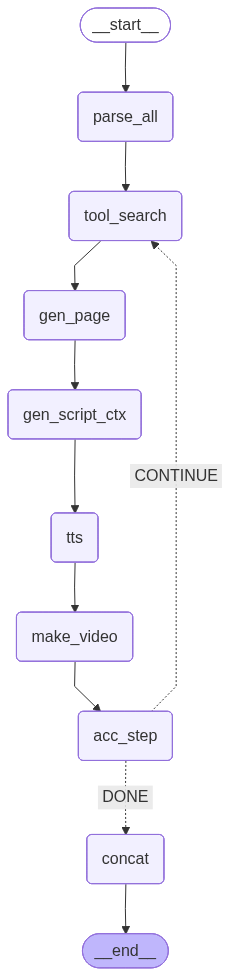

In [64]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("parse_all", node_parse_all)
builder.add_node("tool_search", node_tool_search)
builder.add_node("gen_page", node_generate_page_content)
builder.add_node("gen_script_ctx", node_generate_script_with_context)
builder.add_node("tts", node_tts)
builder.add_node("make_video", node_make_video)
builder.add_node("acc_step", node_accumulate_and_step)
builder.add_node("concat", node_concat)

# 추가 노드 (summary)
builder.add_node("gen_summ_txt", node_generate_summary_text)
builder.add_node("summ_tts", node_summary_tts)
builder.add_node("summ_video", node_summary_video)
builder.add_node("gen_summ_pdf", export_state_to_pdfs)

builder.add_edge(START, "parse_all")
builder.add_edge("parse_all", "tool_search")
builder.add_edge("tool_search", "gen_page")
builder.add_edge("gen_page", "gen_script_ctx")
builder.add_edge("gen_script_ctx", "tts")
builder.add_edge("tts", "make_video")
builder.add_edge("make_video", "acc_step")
builder.add_conditional_edges("acc_step", router_continue_or_done,
                             {"CONTINUE":"tool_search", "DONE":"gen_summ_txt"} )
# 연결 엣지 추가
builder.add_edge("gen_summ_txt", "summ_tts")
builder.add_edge("summ_tts", "summ_video")
builder.add_edge("summ_video", "concat")
builder.add_edge("concat", "gen_summ_pdf")
builder.add_edge("gen_summ_pdf", END)

app = builder.compile()

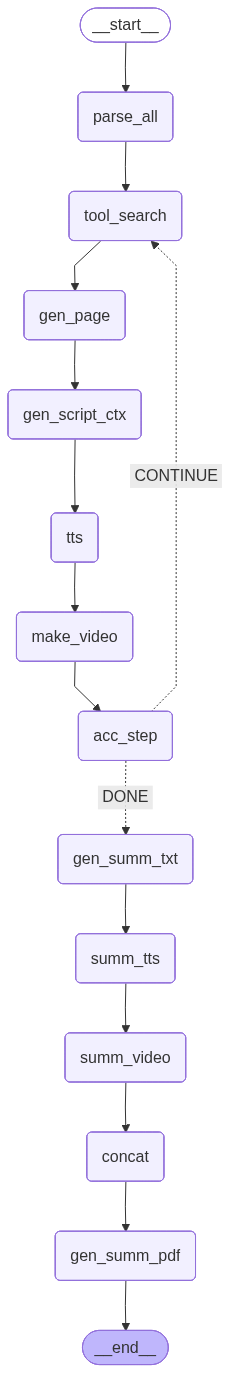

In [65]:
from IPython.display import Image, display

# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

## **4. 시스템 실행**

미션3,4에서 수행한 결과를 통합 테스트 해 봅시다.

### (1) 준비 작업
* 파일 업로드
* 사용자 프롬프트 준비

In [66]:
# 파일 업로드
uploaded = files.upload()
pptx_path = list(uploaded.keys())[0]

Saving sample2_test.pptx to sample2_test (1).pptx


In [67]:
# 사용자 프롬프트
USER_PROMPT = {
    "voice": "alloy",
    "tone": "친절하고 명료한 강의 톤",
    "style": "예시와 핵심 요점 중심"
}
# 출력 dir 만들기
WORK_DIR = "./step2_output"
MEDIA_DIR = "./step2_output/media"
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MEDIA_DIR, exist_ok=True)

### (2) Agent 실행
* State 초기화
* app 실행
    * 실행 시, 잘못된 반복 실행이 발생될 수 있으므로 다음 옵션 적용
        * `app.invoke(state, config={"recursion_limit": 100})`
        * 숫자 100은 조정 가능
* 동영상 play

### (3) 추가기능 : 다국어


In [68]:
LANG_OPTIONS = {
    "ko": {"name": "한국어", "voice": "alloy"},
    "en": {"name": "English", "voice": "verse"},
    "ja": {"name": "日本語", "voice": "shimmer"},
    "zh-cn": {"name": "中文", "voice": "coral"},
    "fr": {"name": "Français", "voice": "sage"}
}

In [69]:
from openai import OpenAI
client = OpenAI()

def translate_text(text: str, target_lang: str) -> str:
    """LLM을 사용해 텍스트를 target_lang으로 번역"""
    try:
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": f"당신은 전문 번역가입니다. 모든 문장을 자연스럽고 문맥에 맞게 {LANG_OPTIONS[target_lang]['name']}로 번역하세요."},
                {"role": "user", "content": text}
            ],
            temperature=0.3,
            max_tokens=1500
        )
        return resp.choices[0].message.content.strip()
    except Exception as e:
        print(f"[번역 오류] {e}")
        return text  # 실패 시 원문 유지

In [70]:
from pptx import Presentation
from pptx.util import Pt, Inches
from pptx.enum.text import MSO_AUTO_SIZE

# (선택) 기본 폰트 크기/상자 리사이즈 기준을 상수로 빼두면 관리가 쉬움
DEFAULT_PT = 18        # 기본 글자 크기
MIN_PT     = 12        # 최소 글자 크기
LONG_LEN1  = 120       # 텍스트 길이가 이 이상이면 상자 조금 키움
LONG_LEN2  = 220       # 이 이상이면 상자 더 키움

def translate_pptx(input_path: str, output_path: str, target_lang: str):
    prs = Presentation(input_path)
    print(f"[PPT 번역] {target_lang}로 번역 시작...")

    for si, slide in enumerate(prs.slides):
        for shape in slide.shapes:
            # 텍스트 프레임이 없는 도형/그림은 스킵
            if not getattr(shape, "has_text_frame", False):
                continue
            if not shape.has_text_frame:
                continue

            tf = shape.text_frame
            original_text = (tf.text or "").strip()
            if not original_text:
                continue

            # 1) 번역
            translated = translate_text(original_text, target_lang)
            tf.text = translated  # 기존 텍스트 대체

            # 2) 줄바꿈/오토사이즈/워드랩 설정
            tf.word_wrap = True
            # 글자를 상자에 맞추는 자동 줄이기: TEXT_TO_FIT_SHAPE
            # (상자 크기 유지 + 글자 크기 줄이기)
            try:
                tf.auto_size = MSO_AUTO_SIZE.TEXT_TO_FIT_SHAPE
            except Exception:
                # 일부 템플릿에서 속성 미지원일 경우 무시
                pass

            # 3) 글자 크기 보정
            #    - 번역 전/후 길이 비로 글자 크기 약간 자동 축소
            orig_len = max(len(original_text), 1)
            trans_len = len(translated)
            ratio = trans_len / orig_len

            # 길이가 늘어나면 글자 크기를 줄임 (하한 MIN_PT)
            target_pt = DEFAULT_PT
            if ratio > 1.0:
                target_pt = max(int(DEFAULT_PT / min(ratio, 1.8)), MIN_PT)

            for p in tf.paragraphs:
                for run in p.runs:
                    run.font.size = Pt(target_pt)

            # 4) 내용이 긴 경우 텍스트 박스 넓힘/높임 (상태에 따라 보정)
            #    - too long 이면 상자 키워서 잘림 방지
            try:
                if trans_len > LONG_LEN2:
                    shape.width  = max(shape.width,  Inches(9))   # 가로 크게
                    shape.height = max(shape.height, Inches(3.2)) # 세로 크게
                elif trans_len > LONG_LEN1:
                    shape.width  = max(shape.width,  Inches(8))   # 가로 보정
                    shape.height = max(shape.height, Inches(2.4)) # 세로 보정
            except Exception:
                # 마스터/플레이스홀더 등 일부 객체는 크기 수정 불가 → 무시
                pass

            print(f" - 슬라이드{si+1}: '{original_text[:20]}...' → '{translated[:20]}...'  "
                  f"(pt≈{target_pt}, len={trans_len})")

    prs.save(output_path)
    print(f"[PPT 번역 완료] 저장 경로: {output_path}")


In [71]:
# State 초기화
state: State = {
    "pptx_path": pptx_path,
    "work_dir": WORK_DIR,
    "prompt": USER_PROMPT,
    "slide_index": 0,
    "slides": [],
    "merged_video": ""
}

# 필요 전역변수
prev_context = ""
total_slides = 0

In [72]:
res = app.invoke(state, config={"recursion_limit":100})

[Debug] 📝  정보 분해 시작...
[Debug] 슬라이드 이미지 생성 /content/step2_output/sample2_test (1).png
[Debug] Slide0 : 4 texts, 0 tables, 1 images
[Debug] 슬라이드 이미지 생성 /content/step2_output/slide_img-2.png
[Debug] Slide1 : 4 texts, 0 tables, 1 images
[Debug] 슬라이드 이미지 생성 /content/step2_output/slide_img-3.png
[Debug] Slide2 : 4 texts, 1 tables, 0 images
[Debug] ✅ 3개 슬라이드 파싱 완료
[Debug] 🎤 [친절하고 명료한 강의 톤 / 예시와 핵심 요점 중심] 스타일로 발표 스크립트 생성 시작...
[Debug] ✅ 슬라이드0: '모델 성능 모니터링' 스크립트 저장 완료 (668자)
[Debug] 🔊 TTS 생성 중... (voice=alloy)
[Debug] ✅ TTS 생성 완료: ./step2_output/narration_slide0.mp3 (길이: 94.01초)
[Debug] 🎬 슬라이드별 영상 생성 시작...
[Debug] 영상 생성 중... (slide0_lecture.mp4)
[Debug] 영상 생성 완료: ./step2_output/slide0_lecture.mp4
[Debug] 🎬 슬라이드0 영상 생성 완료
[Debug] slide_index=0, total=3
[Debug] ▶ 다음 슬라이드로 이동: 1
[Debug] slide_index=1, total=3
[Debug] ▶ 다음 슬라이드 존재 → CONTINUE 반환
[Debug] 🎤 [친절하고 명료한 강의 톤 / 예시와 핵심 요점 중심] 스타일로 발표 스크립트 생성 시작...
[Debug] ✅ 슬라이드1: 'ML 모델에 영향을 줄 수 있는 요인' 스크립트 저장 완료 (797자)
[Debug] 🔊 TTS 생성 중... (voice=alloy

In [73]:
# video_path = res['merged_video']
video_path = './step2_output/final_merged_lecture.mp4'

with open(video_path, "rb") as f:
    data = f.read()

display(Video(data=data, embed=True, mimetype="video/mp4", width=960))

Output hidden; open in https://colab.research.google.com to view.

## **5. Web APP 개발(Gradio)**
* 화면 개발
    * 입력 : ppt파일, 프롬프트(강의 작성톤), voice 선택(alloy, ...)
    * 출력 : 동영상 play, 동영상 다운로드 버튼
* 기본 화면을 제공합니다. 필요한 기능을 직접 추가하세요.

In [74]:
import os, time, shutil
import gradio as gr
# State, app 등은 이미 정의되어 있다고 가정합니다.
# from your_agent_file import app, State

VOICES = ["alloy", "aria", "verse", "shimmer", "coral", "sage", "tenor", "nova", "amber"]

def run_pipeline_ui(pptx_file, tone, voice, lang_code): #lang code 추가

    # 파일 미첨부 예외 처리
    if pptx_file is None:
        gr.Warning(" PPTX 파일을 먼저 업로드해 주세요!!!")
        return None, None

    # 작업 디렉터리 & 업로드 저장
    work_dir = os.path.join("./webio", f"run-{int(time.time())}")
    os.makedirs(work_dir, exist_ok=True)
    pptx_path = os.path.join(work_dir, "input.pptx")
    shutil.copy(pptx_file.name, pptx_path)

    # ppt 생성
    if lang_code != "ko":  # 한국어가 아닐 때만 번역
      translated_path = os.path.join(work_dir, f"translated_{lang_code}.pptx")
      translate_pptx(pptx_path, translated_path, lang_code)
      pptx_path = translated_path  # 이후 파이프라인은 번역된 PPT 사용


    #언어선택 및 보이스 설정
    lang_cfg = LANG_OPTIONS.get(lang_code, LANG_OPTIONS["en"])
    language_name = lang_cfg["name"]
    voice = lang_cfg["voice"] if not voice else voice


    # 초기 state (State 스키마에 맞춤)
    # (대헌님이 수정하신 state 구조를 그대로 사용합니다)
    state: State = {
        "pptx_path": pptx_path,
        "work_dir": work_dir,
        "prompt": {"voice":voice,
                   "tone":tone,
                   "style":"예시와 핵심 요점 중심",
                   "language": language_name, #추가
                   "lang_code": lang_code,    #추가
                   },
        "slide_index": 0,
        "slides": [],
        "merged_video": ""
    }

    # (app.invoke가 State 타입을 받는다고 가정)
    # 필요 전역변수 (이 변수들이 Agent 내부에서 사용되지 않는다면 제거해도 됩니다)
    prev_context = ""
    total_slides = 0

    # 그래프 실행
    final_state = app.invoke(state)
    video_path = final_state.get("merged_video")

    if not video_path or not os.path.exists(video_path):
        print(f"오류: 비디오 경로를 찾을 수 없습니다. (Path: {video_path})")
        gr.Warning("비디오 생성에 실패했습니다. 로그를 확인하세요.")
        return None, None

    return video_path, video_path

# -------------------- Gradio UI (Styled) --------------------

# UI를 꾸미기 위해 Soft 테마를 적용합니다.
with gr.Blocks(theme=gr.themes.Soft(primary_hue="lime", secondary_hue="teal"), title="AI 강의 영상 Agent ") as demo:

    # 1. 헤더 섹션
    gr.Markdown(
        """
        <div style="text-align: center; max-width: 800px; margin: auto;">
        <h1 style="color: #3B82F6; font-size: 2.5rem; font-weight: 700;"> 🧑‍🏫 AI 강의 영상 Agent</h1>
        <p style="font-size: 1.1rem; color: #551;">PPT 파일을 업로드하면 AI가 자동으로 강의 영상을 제작해 드립니다.</p>
        </div>
        """
    )

    # 2. 메인 컨텐츠 (입력/출력 분리)
    with gr.Row(equal_height=False):

        # 2-1. 왼쪽: 입력 및 설정 컬럼
        with gr.Column(scale=1, min_width=400):
            with gr.Group():
                gr.Markdown("### 1. 설정 입력")
                inp_ppt = gr.File(
                    label="PPTX 업로드",
                    file_types=[".pptx"]

                )
                inp_lang = gr.Dropdown(
                    choices=[(v["name"], k) for k, v in LANG_OPTIONS.items()],
                    value="ko",
                    label="🌐 강의 언어 선택"
                )

                # 언어 상태 표시용
                lang_status = gr.Markdown("✅ 현재 선택된 언어: **한국어 🇰🇷**")

                # 언어 변경 시 즉시 UI에 표시되는 함수
                def update_lang_display(lang_code):
                    lang_name = LANG_OPTIONS.get(lang_code, {}).get("name", "Unknown")
                    flags = {"ko": "🇰🇷", "en": "🇺🇸", "ja": "🇯🇵", "zh-cn": "🇨🇳", "fr": "🇫🇷"}
                    flag = flags.get(lang_code, "🌍")
                    print(f"[UI] 🌐 언어 변경 감지 → {lang_name}")
                    return f"✅ 현재 선택된 언어: **{lang_name} {flag}**"

                # 언어 변경 이벤트 연결
                inp_lang.change(fn=update_lang_display, inputs=inp_lang, outputs=lang_status)

                inp_tone = gr.Textbox(
                    value="친절하고 명료한 강의 톤",
                    label="강의 작성 톤 (프롬프트)",
                    info="AI 강사의 전반적인 말투를 설정합니다."
                )
                inp_voice = gr.Dropdown(
                    VOICES,
                    value="alloy",
                    label="TTS Voice",
                    info="AI 강사의 목소리 종류를 선택합니다."
                )

            run_btn = gr.Button("🎬 영상 제작 시작", variant="primary", scale=2)

        # 2-2. 오른쪽: 출력 컬럼
        with gr.Column(scale=2, min_width=600):
            with gr.Group():
                gr.Markdown("### 2. 제작된 영상")
                out_video = gr.Video(
                    label="최종 동영상 미리보기",
                    interactive=False,
                    height=480
                )
                out_download = gr.DownloadButton(
                    label=" ⬇ 동영상 다운로드",
                    variant="secondary"
                )

    # 3. 버튼 클릭 이벤트 연결 (기존과 동일)
    run_btn.click(
        # 1-1. 버튼을 "제작 중..."으로 바꾸고 비활성화, 이전 결과물(out_video)을 None으로 초기화
        fn=lambda: [
            gr.update(value="⏳ 제작 중...", interactive=False),
            gr.update(value=None),
            gr.update(value=None)
        ],
        inputs=None,
        outputs=[run_btn, out_video, out_download]

    ).then(
        # 1-2. (1-1이 끝나면) 실제 작업 함수(run_pipeline_ui) 실행
        fn=run_pipeline_ui,
        inputs=[inp_ppt, inp_tone, inp_voice, inp_lang],
        outputs=[out_video, out_download]

    ).then(
        # 1-3. (1-2가 끝나면) 버튼을 다시 "영상 제작 시작"으로 복구
        fn=lambda: gr.update(value="🎬 영상 제작 시작", interactive=True),
        inputs=None,
        outputs=run_btn
    )

# (demo.launch()는 실제 실행 환경에서 호출합니다)
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2331fcb09c1ad0d810.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
